## **REFERENCE FULL ORDER PROBLEM**

#### LOAD LIBRARIES

In [1]:
# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import itertools
import time
import sys

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

#### DEFINE REFERENCE PROBLEM PARAMETERS

In [2]:
## Define universal constants:
N_AVOG = 6.022141E+23  # [-]
N_BOLT = 1.380649E-23  # [-]

# Define geometrical parameters:
RADIUS = 1.00E-05  # [m]
LENGTH = 1.00E-03  # [m]

# Define fission rate:
FISSION_RATE = 3.00E+19 

# Define sources intensity:
SOURCE_T = FISSION_RATE * 7.27E-18  # [K/s]
SOURCE_C = FISSION_RATE * 0.24E+00  # [atm / (m^3 s)]

# Define temperatur diffusion coefficient and forcing dimensionless group:
ALPHA_T = 5.00E-07                        # [m^2 / s]
GAMMA_T = SOURCE_T * LENGTH**2 / ALPHA_T  # [ - ]
                       
# Define reference temperature, concentration and linear diffusion parameters:
T_BC, T_IC = 2.00E+03, 2.00E+03  # [K]
C_BC, C_IC = 0.00E+00, 0.00E+00  # [atm / m^3]

# Define forcing dimensionless group:
GAMMA_T = SOURCE_T * LENGTH**2 / ALPHA_T

# Define final time, time increment:
TIME_FINAL = 1.00E+07  # [s]
TIME_DELTA = 1.00E+04  # [s]

# Compute number of iterations:
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T):
    return 5.0e-08 * np.exp(-40262.0 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2));

#### IDENTIFY DIRICHLET DOFS AND INTERNAL DOFS

In [3]:
# Load coordinates:
coordinates_Px = FFvector_fread('vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([np.linalg.norm(coordinates_Px[ii, :2]) for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_mid_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

#### DEFINE FINITE ELEMENT ESSENTIALS

In [4]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('ww_mm_Pq.btxt')

# Compute volume of the domain:
volume = mass_Px.dot(np.ones(sFO_Px)).dot(np.ones(sFO_Px))

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('ww_dy_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdz_C = project_Pq.dot(FFmatrix_fread('ww_dz_Px_Pq.btxt')[:, mask_in_C])

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(weights_Pq[:, None]))
inte_C = mass_Px.dot(np.ones((sFO_Px)))[mask_in_C] / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / RADIUS**2 * weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / RADIUS**2 * weights_Pq[:, None])) + \
          PxtoPqdz_C.T.dot(PxtoPqdz_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / LENGTH**2 * weights_Pq[:, None]))

#### IMPLEMENT FULLY IMPLICID FORWARD EULER FOR THE CONCENTRATION ONLY

In [5]:
# Initialise temperature and concentration solution containing the deviation from the initial condition:
sol_new_C = np.zeros((sFO_Px, N_ITER+1)) 

# Integrate using forward Euler up to the final time:
for ii in range(N_ITER):
    cur_time = ii * TIME_DELTA

    # Print current iteration and average temperature and concentration:
    print('Current time:', cur_time, 's')
    print('Average concentration:', inte_C @ sol_new_C[mask_in_C, ii], 'atm/m^3\n')

    # Assemble current left-hand-side and right-hand-side
    cur_lhs = mass_C + TIME_DELTA * stiff_C
    cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + TIME_DELTA * (SOURCE_C * forc_C)

    # Compute perturbation from the initial temperature and concentration in the interior of the domain:
    sol_new_C[mask_in_C, ii+1], _ = linalg.bicgstab(cur_lhs, cur_rhs)

# Print final time and final average temperature and concentration:
print('Final time:', N_ITER * TIME_DELTA, 's')
print('Average concentration:', mass_Px.dot(sol_new_C[:, -1]).dot(np.ones((sFO_Px, 1)))[0] / volume, 'atm/m^3')

Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 10000.0 s
Average concentration: 4.714990389993852e+22 atm/m^3

Current time: 20000.0 s
Average concentration: 8.362529268356222e+22 atm/m^3

Current time: 30000.0 s
Average concentration: 1.1305270441162989e+23 atm/m^3

Current time: 40000.0 s
Average concentration: 1.3730307765951196e+23 atm/m^3

Current time: 50000.0 s
Average concentration: 1.5756882875400174e+23 atm/m^3

Current time: 60000.0 s
Average concentration: 1.7468753237138316e+23 atm/m^3

Current time: 70000.0 s
Average concentration: 1.8927842166943288e+23 atm/m^3

Current time: 80000.0 s
Average concentration: 2.0181250880097186e+23 atm/m^3

Current time: 90000.0 s
Average concentration: 2.126561256346492e+23 atm/m^3

Current time: 100000.0 s
Average concentration: 2.2209736385027425e+23 atm/m^3

Current time: 110000.0 s
Average concentration: 2.3036555996335498e+23 atm/m^3

Current time: 120000.0 s
Average concentration: 2.376449435164163e+23 atm/m^

## **REDUCED BASIS MODEL CONSTRUCTION**

#### DEFINE PARAMETERS TRAINING SET
$\Xi_{train}$

In [6]:
# Define size of the training parameter set:
sTR = 10000

# Define parameters ranges:
MIN_FR, MAX_FR = 2.00E+19, 3.00E+19 
MIN_BC, MAX_BC = 1.75E+03, 2.5E+03
MIN_LL, MAX_LL = 0.75E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5
#MIN_FY, MAX_FY = 0.00, 0.3 
#MIN_Q, MAX_Q =                                                             #q''' [W/m^3]
#MIN_RHO, MAX_RHO =                                                         #rho[Kg/m^3]
#MIN_CP, MAX_CP =                                                           #Cp[J/(Kg K)]
#MIN_FH , MAX_FH = MIN_Q/(MIN_RHO*MIN_CP), MAX_Q/(MAX_RHO*MAX_CP)           #fission heat
#MIN_K, MAX_K =                                                             #[W/(m K)]
#MIN_ALPHA, MAX_ALPHA = MIN_K/(MIN_RHO*MIN_CP), MAX_K/(MAX_RHO*MAX_CP)      #k/(rho Cp)
MIN_GG, MAX_GG = (7.27E-18 / 5.00E-07) * MIN_FR * MIN_LL**2, (7.27E-18 / 5.00E-07) * MAX_FR * MAX_LL**2
#MIN_GG, MAX_GG = (MIN_FH / MIN_ALPHA) * MIN_FR* MIN_LL**2,   (MAX_FH / MAX_ALPHA) * MAX_FR* MAX_LL**2

# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
LIST_GG = (7.27E-18 / 5.00E-07) * LIST_FR * LIST_LL**2

# Extract z coordinates from the list of all Pq points coordinates and map those coordinates to the Pq points:
ZZ = np.sort(list(set(coordinates_Pq[:, 2])))
ZZ_1Dto3D = sparse.csr_matrix(np.array([coordinates_Pq[:, 2] == ZZ[kk] for kk in range(len(ZZ))]).T) * 1

# Compute a training set of concentration diffusion coefficients evaluated at the z coordinates: 
TRAINING = np.empty((len(ZZ), sTR))
for ii in range(sTR):
    TRAINING[:, ii] = ALPHA_C(ZZ, T_BC=LIST_BC[ii], GAMMA_T=LIST_GG[ii])

#### CONSTRUCT AN AFFINE DECOMPOSITION FOR THE CONCENTRATION DIFFUSION COEFFICIENTS

Ora costruiamo le basi $\zeta_i(\mathbf{x})$

In [7]:
# Compress the training set using singular value decomposition:
UU, SS, VV = np.linalg.svd(TRAINING @ TRAINING.T, full_matrices=False)
NN = np.sum(np.sqrt([np.sum(SS[ii:]) / np.sum(SS) for ii in range(len(SS))]) > 1e-6) + 1 

# Construct 1D and 3D basis for the concentration diffusion coefficient:
BASIS_D_1D = UU[:, :NN]
BASIS_D_3D = ZZ_1Dto3D @ BASIS_D_1D

# Use a greedy algorithm to identify the points (indeces) to interpolate the exact concentration coefficients:
INT_COO = [np.argmax(np.abs(BASIS_D_1D[:, 0]))]
for ii in range(1, NN):
    INT_COO.append(np.argmax(np.abs(BASIS_D_1D[:, ii] - BASIS_D_1D[:, :ii] @ np.linalg.solve(BASIS_D_1D[INT_COO, :ii],  BASIS_D_1D[INT_COO, ii]))))

# Extrat the z coordinates associated with the selected indeces: CO = indici sul vettore delle posizioni.   
INT_COO = np.array(INT_COO)
INT_CZZ = np.array([ZZ[INT_COO[ii]] for ii in range(NN)])

# Define interpolation operator mapping from the diffusion coefficient evaluated in the interpolation points to the linear combination coefficients:
mapDAtoCO = np.linalg.solve(BASIS_D_1D[INT_COO, :], np.eye(NN))

# Estimate the absolute and relative errors committed with this interpolation approach:
ABS_ERR = np.linalg.norm(TRAINING - BASIS_D_1D @ mapDAtoCO @ TRAINING[INT_COO, :], axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(TRAINING, axis=0)

# Print maximum error:
print(np.max(REL_ERR))
print(VV.shape)

1.5701689779675668e-06
(190, 190)


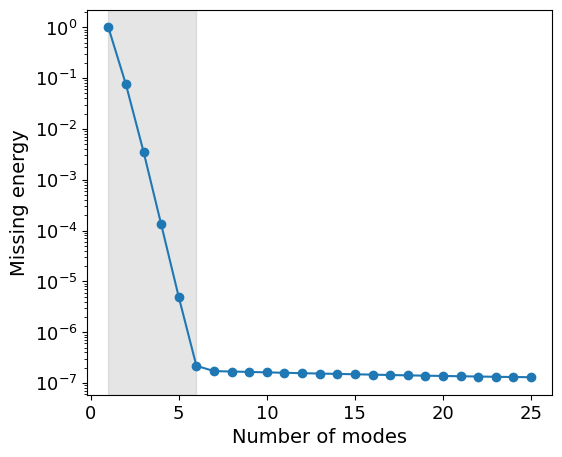

In [8]:
#guardiamo la missing energy del termine non-affine -> queste basi ridotte dopo le usiamo per davvero
missing = np.sqrt([np.sum(SS[ii:]) / np.sum(SS) for ii in range(len(SS))])
fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.set_yscale('log')
ax1.plot(range(1,26), missing[:25], '-o')
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.set_xlabel('Number of modes',fontsize=14)
ax1.set_ylabel('Missing energy',fontsize=14)
ax1.axvspan(1, NN, color='gray', alpha=0.2)

#### ASSEMBLE AFFINELY DECOMPOSED STIFFNESS MATRICES AND COMPUTE THEIR COERCIVITY CONSTANTS

In [9]:
# Define two mass matrices respectively linked to the regularity of the solution and of its time derivative:
Y_mass = stiff_C
X_mass = mass_C

# Initialise array for the partial stiffness matrices and for their coercivity constants:
list_basis_stiff_C = np.array([sparse.csr_matrix((mass_C.shape)) for ii in range(2*NN)])
list_coerc_stiff_C = np.zeros((2*NN))

# Iterate over the selected basis for the diffusion coefficient field
for ii in range(NN):

    # Assemble the axial and radial partial stiffness matrices associated with the basis of the diffusivity:
    list_basis_stiff_C[NN+ii] = PxtoPqdz_C.T.dot(PxtoPqdz_C.multiply(BASIS_D_3D[:, ii:ii+1] * weights_Pq[:, None]))
    list_basis_stiff_C[00+ii] = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(BASIS_D_3D[:, ii:ii+1] * weights_Pq[:, None])) + \
                                PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(BASIS_D_3D[:, ii:ii+1] * weights_Pq[:, None]))

    # Compute the sign of the axial and radial partial stiffness matrices:
    tsign_dz_C = np.sign(list_basis_stiff_C[NN + ii].trace())
    tsign_dr_C = np.sign(list_basis_stiff_C[00 + ii].trace())

    # Compute the coercivity constant of the axial and radial partial stiffness matrices:
    list_coerc_stiff_C[NN+ii] = tsign_dz_C / linalg.eigsh(Y_mass, k=1, M=tsign_dz_C * list_basis_stiff_C[NN+ii], which='LM', return_eigenvectors=False)[0]
    list_coerc_stiff_C[00+ii] = tsign_dr_C / linalg.eigsh(Y_mass, k=1, M=tsign_dr_C * list_basis_stiff_C[00+ii], which='LM', return_eigenvectors=False)[0]

#### COMPUTE THE INTERPOLATION COEFFICIENTS AND THE COERCIVITY COEFFICIENTS FOR ALL THE PARAMETERS

In [11]:
# Compute the interpolation coefficients and the coercivity coefficients for the parameters in the training set:
list_inter_coef = np.empty((sTR, 2*NN))
list_coerc_coef = np.empty((sTR))

# Iterate over the training set:
for ii in range(sTR):
    cur_coef = mapDAtoCO @ ALPHA_C(INT_CZZ, T_BC=LIST_BC[ii], GAMMA_T=LIST_GG[ii])

    # Compute the interpolation coefficients for the radial and axial partial stiffness matrices:
    list_inter_coef[ii, NN:] = cur_coef / LIST_LL[ii]**2
    list_inter_coef[ii, :NN] = cur_coef / LIST_RR[ii]**2

    # Compute a lower bound for the coercivity constants:
    list_coerc_coef[ii] = np.dot(list_coerc_stiff_C, list_inter_coef[ii, :])

# Compute interpolation and coercivity coeffientrs for the reference parameters:
cur_inter_coef = mapDAtoCO @ ALPHA_C(INT_CZZ, T_BC=T_BC, GAMMA_T=GAMMA_T)
cur_inter_coef = np.hstack((cur_inter_coef / RADIUS**2, cur_inter_coef / LENGTH**2))
cur_coerc_coef = np.dot(list_coerc_stiff_C, cur_inter_coef)

#### COMPUTE THE POD MODES OF THE REFERENCE SOLUTION

In [12]:
# Compute the singular value decomposition of the gramian matrix:
AA, GG, BB = np.linalg.svd(sol_new_C[mask_in_C, :].T @ Y_mass @ sol_new_C[mask_in_C, :], full_matrices=False)

# Compute total Y-energy of the training set:
Y_energy = np.sum([Y_mass.dot(sol_new_C[mask_in_C, ii]).dot(sol_new_C[mask_in_C, ii]) for ii in range(N_ITER+1)])

# Determine number of POD modes to retain:
sRB_C = np.sum([np.sqrt(np.sum(GG[ii:]) / Y_energy) > 1e-4 for ii in range(len(GG))])

# Assemble POD modes for the concentration field at the reference parameters:
BASIS_C_3D = sol_new_C[mask_in_C, :] @ AA[:, :sRB_C] @ np.diag(np.reciprocal(np.sqrt(GG[:sRB_C])))

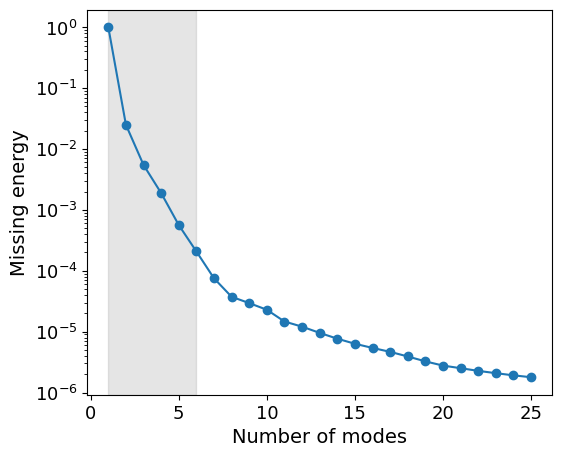

In [13]:
#guardiamo la missing energy della C -> queste basi ridotte le usiamo solo al 2° blocco sotto. è implicita. Questo non è il modello ridotto che passiamo a SCIANTIX ma serve dopo 
#per controllare che tutto funzioni
missing = [np.sqrt(np.sum(GG[ii:]) / Y_energy) for ii in range(len(GG))]   #quella che mostr
fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.set_yscale('log')
ax1.plot(range(1,26), missing[:25], '-o')
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.set_xlabel('Number of modes',fontsize=14)
ax1.set_ylabel('Missing energy',fontsize=14)
ax1.axvspan(1, sRB_C, color='gray', alpha=0.2)

#### ASSEMBLE REDUCED MATRICES (LATER MUST BE CODED AS THE METHOD OF A CLASS)

In [14]:
# Project the Y- and X-mass matrices on the reduced basis space:
Y_mass_RB = BASIS_C_3D.T @ Y_mass @ BASIS_C_3D
X_mass_RB = BASIS_C_3D.T @ X_mass @ BASIS_C_3D

# Compute Rietz representer and projection of the forcing term:
forc_C_rietz_RB = linalg.spsolve(Y_mass, forc_C)
forc_C_proje_RB = BASIS_C_3D.T @ forc_C

# Compute Rietz representer and projection of the mass matrix tested versus the POD basis functions: 
mass_C_right_RB = mass_C @ BASIS_C_3D
mass_C_rietz_RB = linalg.spsolve(Y_mass, mass_C_right_RB)
mass_C_proje_RB = BASIS_C_3D.T @ mass_C_right_RB

# Compute the Rietz representer and projection of all the partial stiffness matrices from the affine decomposition:
list_basis_stiff_C_right_RB = np.array([list_basis_stiff_C[ii] @ BASIS_C_3D for ii in range(2*NN)])                      #lista delle basi della forma bilineare testate a destra con basi ridotte
list_basis_stiff_C_rietz_RB = np.array([linalg.spsolve(Y_mass, list_basis_stiff_C_right_RB[ii]) for ii in range(2*NN)])
list_basis_stiff_C_proje_RB = np.array([BASIS_C_3D.T @ list_basis_stiff_C_right_RB[ii] for ii in range(2*NN)])

# Pre-assemble the scalar and vector terms for the residual energy computation:
DD_pr_bb = (forc_C_rietz_RB.T @ forc_C) * (SOURCE_C * SOURCE_C)
DD_pr_bm = (forc_C_rietz_RB.T @ mass_C_right_RB) * (- 2 * SOURCE_C / TIME_DELTA)
DD_pr_mm = (mass_C_rietz_RB.T @ mass_C_right_RB) * (  1 / (TIME_DELTA * TIME_DELTA))

# Pre-assemble all the tensor terms for the residual energy computation:
DD_pr_ab = np.array([ list_basis_stiff_C_right_RB[ii, :, :].T @ forc_C_rietz_RB for ii in range(2*NN)]) * (-2 * SOURCE_C)
DD_pr_am = np.array([ list_basis_stiff_C_right_RB[ii, :, :].T @ mass_C_rietz_RB for ii in range(2*NN)]) * ( 2 / TIME_DELTA)
DD_pr_aa = np.array([[list_basis_stiff_C_right_RB[ii, :, :].T @ list_basis_stiff_C_rietz_RB[jj, :, :] for ii in range(2*NN)] for jj in range(2*NN)])

# Compute the weights for the integration of the reduced basis solutions:
weights_RB = np.ones((sFO_Px)) @ mass_Px[:, mask_in_C] @ BASIS_C_3D

KeyboardInterrupt: 

#### COMPUTE REDUCED BASIS SOLUTION

In [21]:
# Assemble current reduced basis stiffness matrix:
stiff_C_proje_RB = np.tensordot(cur_inter_coef, list_basis_stiff_C_proje_RB, axes=[0, 0])
stiff_C_exact_RB = BASIS_C_3D.T @ stiff_C @ BASIS_C_3D

# Assemble current stiffness cross term for the computation of the residual energy:
cur_DD_pr_ab = np.tensordot(cur_inter_coef, DD_pr_ab, axes=[0, 0])
cur_DD_pr_am = np.tensordot(cur_inter_coef, DD_pr_am, axes=[0, 0])
cur_DD_pr_aa = np.tensordot(cur_inter_coef, np.tensordot(cur_inter_coef, DD_pr_aa, axes=[0, 0]), axes=[0, 0])

# Initialise reduced basis concentration solution:
sol_new_C_RB = np.zeros((sRB_C, N_ITER+1))
sol_new_C_FO = np.zeros((len(mask_in_C), N_ITER+1))

# Initialise errors and errors estimators:
energy_residual = np.empty((N_ITER))
energy_solution = np.empty((N_ITER))
energy_toterror = np.empty((N_ITER))

# Integrate using forward Euler up to the final time:
verbose = True
for ii in range(N_ITER):
    cur_time = ii * TIME_DELTA

    # Print current iteration and average temperature and concentration:
    if verbose:
        print('Current time:', cur_time, 's')
        print('Average concentration:', np.dot(sol_new_C_RB[:, ii], weights_RB) / volume, 'atm/m^3\n')

    # Assemble current left-hand-side and right-hand-side
    cur_lhs_RB = mass_C_proje_RB + TIME_DELTA * stiff_C_proje_RB
    cur_rhs_RB = mass_C_proje_RB.dot(sol_new_C_RB[:, ii:ii+1]) + TIME_DELTA * SOURCE_C * forc_C_proje_RB

    # Compute concentration in the interior of the domain:
    sol_new_C_RB[:, ii+1] = np.linalg.solve(cur_lhs_RB, cur_rhs_RB)[:, 0]
    sol_new_C_FO[:, ii+1] = BASIS_C_3D @ sol_new_C_RB[:, ii+1]
    
    # Compute partial errors and error bounds:
    energy_toterror[ii] = TIME_DELTA * stiff_C.dot(sol_new_C_FO[:, ii+1] - sol_new_C[mask_in_C, ii+1]).dot(sol_new_C_FO[:, ii+1] - sol_new_C[mask_in_C, ii+1])
    energy_solution[ii] = TIME_DELTA * stiff_C_proje_RB.dot(sol_new_C_RB[:, ii+1]).dot(sol_new_C_RB[:, ii+1])                                                       
    energy_residual[ii] = TIME_DELTA * (DD_pr_bb[0] + DD_pr_bm.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]) +\
                                        DD_pr_mm.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]).dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]) +\
                                        cur_DD_pr_ab.dot(sol_new_C_RB[:, ii+1]) + cur_DD_pr_aa.dot(sol_new_C_RB[:, ii+1]).dot(sol_new_C_RB[:, ii+1]) +\
                                        cur_DD_pr_am.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]).dot(sol_new_C_RB[:, ii+1]))                           

# Print current iteration and average temperature and concentration:
if verbose: 
    print('Final time:', N_ITER * TIME_DELTA, 's')
    print('Average concentration:', np.dot(sol_new_C_RB[:, ii], weights_RB) / volume, 'atm/m^3\n\n')

# Add final term energies:
energy_solution[-1] += mass_C_proje_RB.dot(sol_new_C_RB[:, -1]).dot(sol_new_C_RB[:, -1])
energy_toterror[-1] += mass_C.dot(sol_new_C[mask_in_C, -1] - sol_new_C_FO[:, -1]).dot(sol_new_C[mask_in_C, -1] - sol_new_C_FO[:, -1])

# Print errors and error bounds:
print('Error bound:', np.sqrt(np.sum(energy_residual) / np.sum(energy_solution) / cur_coerc_coef) )
print('Error exact:', np.sqrt(np.sum(energy_toterror) / np.sum(energy_solution)) )

Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 10000.0 s
Average concentration: 6.085151645824021e+22 atm/m^3

Current time: 20000.0 s
Average concentration: 1.1646229361438534e+23 atm/m^3

Current time: 30000.0 s
Average concentration: 1.6824144957433946e+23 atm/m^3

Current time: 40000.0 s
Average concentration: 2.1692819032854083e+23 atm/m^3

Current time: 50000.0 s
Average concentration: 2.6297789598193954e+23 atm/m^3

Current time: 60000.0 s
Average concentration: 3.067078945212648e+23 atm/m^3

Current time: 70000.0 s
Average concentration: 3.4835774181067946e+23 atm/m^3

Current time: 80000.0 s
Average concentration: 3.881174878832862e+23 atm/m^3

Current time: 90000.0 s
Average concentration: 4.261428982512955e+23 atm/m^3

Current time: 100000.0 s
Average concentration: 4.625646914443238e+23 atm/m^3

Current time: 110000.0 s
Average concentration: 4.9749464058691406e+23 atm/m^3

Current time: 120000.0 s
Average concentration: 5.310298255038186e+23 atm/m^3


#### SAVE ESSENTIAL FILES

In [22]:
# Save essentail files:
np.save('model_files/FF_FO.npy', forc_C)
np.save('model_files/XX_FO.npy', np.array([mass_C]))
np.save('model_files/YY_FO.npy', np.array([stiff_C]))
np.save('model_files/KK_FO.npy', list_basis_stiff_C)
np.save('model_files/CC_FO.npy', list_coerc_stiff_C)
np.save('model_files/ZZ_FO.npy', INT_CZZ)
np.save('model_files/II_FO.npy', mapDAtoCO)
np.save('model_files/AA_FO.npy', inte_C)

In [1]:
# Import libraries:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
import sys

# Import user defined libraries:
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

In [26]:
# Define size of the training parameter set:
sTR = 10000

# Define parameters ranges:
MIN_FR, MAX_FR = 2.00E+19, 3.00E+19 
MIN_BC, MAX_BC = 1.75E+03, 2.25E+03
MIN_LL, MAX_LL = 0.75E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5

# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))

### POD-GREEDY

In [27]:
# Define reference parameters:
cur_FY = 2.40E-01
cur_FR = 3.00E+19 
cur_BC = 2.00E+03
cur_LL = 1.00E-03
cur_RR = 1.00E-05
cur_dt = 1.00E+04

# Define empty basis functions matrix and empty list of error bounds:
cur_basis = np.empty((FiniteElementCylinderSolver.sFO, 0))            #spazio ridotto, proiettare su questo produce zero. 
cur_err_bounds = np.ones((sTR))  

# Enter reduced basis space loop:
new_sRB = np.inf   
while new_sRB > 0: #while np.max(cur_err_bounds) > 1e-02 

    # Assemble full order model and compute full order solution associated with the current parameter selection:
    solver_FO = FiniteElementCylinderSolver()
    solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, F_YIELD=cur_FY, T_BC=cur_BC, dt=cur_dt)
    solution_FO = solver_FO.solve(n_steps=1000, verbose=False)

    # Compute orthogonal complement to the basis function and solution energy:
    orthogonal_FO = solution_FO - cur_basis @ np.linalg.solve(cur_basis.T @ solver_FO.XX_FO @ cur_basis, cur_basis.T @ solver_FO.XX_FO @ solution_FO)
    solution_energy_FO = np.einsum('ik,ik', solver_FO.XX_FO @ solution_FO, solution_FO)                                                                 #equivalente traccia degli autovalori
    
    # Extract the POD basis from the full order solution:
    AA, GG, BB = np.linalg.svd(orthogonal_FO.T @ solver_FO.XX_FO @ orthogonal_FO, full_matrices=False)
    new_sRB = np.sum([np.sqrt(np.sum(GG[ii:]) / solution_energy_FO) > 1e-5 for ii in range(len(GG))])
    cur_basis = np.hstack((cur_basis, orthogonal_FO @ AA[:, :new_sRB] @ np.diag(np.reciprocal(np.sqrt(GG[:new_sRB])))))                                #POD del complemento ortogonale.

    # Assemble reduced basis model:
    solver_RB = ReducedBasisCylinderSolver(cur_basis)                                                                                                  #quando passo le nuove basi ri-assembla il modello ridotto, converrebbe fare l'orlata aggiungendo il pezzo. 
    for kk in range(sTR):
        solver_RB.assemble(F_YIELD=cur_FY, F_RATE=LIST_FR[kk], T_BC=LIST_BC[kk], LENGTH=LIST_LL[kk], RADIUS=LIST_RR[kk], dt=cur_dt)

        # Compute current reduced basis solution and error bound:
        solution_RB, cur_err_bounds[kk] = solver_RB.solve(n_steps=1000, error_bound=True)

    # Identify new parameters where to evaluate the full order model:
    cur_FY = cur_FY
    cur_FR = LIST_FR[np.argmax(cur_err_bounds)]
    cur_BC = LIST_BC[np.argmax(cur_err_bounds)]
    cur_LL = LIST_LL[np.argmax(cur_err_bounds)]
    cur_RR = LIST_RR[np.argmax(cur_err_bounds)]

    # Show worse reconstructed parameter configuration:
    print("The current reduced basis size is", cur_basis.shape[1])
    print("The selected Boundary Temperature is", cur_BC, "K")
    print("The selected Fission Rate is", cur_FR, "f/s")
    print("The selected Grain Length is", cur_LL, "m")
    print("The selected Grain Radius is", cur_RR, "m\n")

The current reduced basis size is 12
The selected Boundary Temperature is 2203.865834596358 K
The selected Fission Rate is 2.013480400815956e+19 f/s
The selected Grain Length is 0.0007511845159152665 m
The selected Grain Radius is 1.191600881309265e-05 m

The current reduced basis size is 19
The selected Boundary Temperature is 1827.9165009677404 K
The selected Fission Rate is 2.9991606755258196e+19 f/s
The selected Grain Length is 0.001244581498826097 m
The selected Grain Radius is 8.3322152386938e-06 m

The current reduced basis size is 28
The selected Boundary Temperature is 2202.069363362402 K
The selected Fission Rate is 2.0182515014999237e+19 f/s
The selected Grain Length is 0.0008085490644310463 m
The selected Grain Radius is 7.599567922880297e-06 m

The current reduced basis size is 30
The selected Boundary Temperature is 1750.771429480188 K
The selected Fission Rate is 2.1287583723084247e+19 f/s
The selected Grain Length is 0.0007664444631267513 m
The selected Grain Radius is 

In [28]:
cur_err_bounds[np.argmax(cur_err_bounds)]

0.00022472104483935954

In [29]:
np.save('basis_1E-5.npy', cur_basis)

### RECONSTRUCTION

In [2]:
#Estraiamo le matrici dal solver
MM_RB = solver_RB.XX_RB    #matrice di massa
FF_RB = solver_RB.FF_RB    #funzionalità contro il vettore unitario 
KK_RB = solver_RB.KK_RB    #basi della decomposizione affine della stiffness
AA_RB = solver_RB.AA_RB    #l'integratore per calcolare il valor medio sul volume data la soluzione ridotta, questo può essere sostituito dalla funzione che calcola il valor medio su diversi slice. 
ZZ_CO = solver_RB.ZZ_FO    #coordinate a cui dobbiamo valutare la temperatura 
II_CO = solver_RB.II_FO    #coefficienti che mappano i valori del coefficiente di diffusione valutata sulle temperature nei coefficienti di combinazione lineare della decomposizione affine. 

NameError: name 'solver_RB' is not defined

In [35]:
TIME_DELTA = 10000
#FISSION_RATE = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(1))
FISSION_RATE = 3e19
SOURCE_T = FISSION_RATE * 7.27E-18
ALPHA_T = 5.00E-07  
#LENGTH = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(1))
LENGTH = 1e-03
#RADIUS = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(1))
RADIUS = 1e-05
#T_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(1))
T_BC = 2000
print("The selected Boundary Temperature is", T_BC, "K")
print("The selected Fission Rate is", FISSION_RATE, "f/s")
print("The selected Grain Length is", LENGTH, "m")
print("The selected Grain Radius is", RADIUS, "m\n")

The selected Boundary Temperature is 2000 K
The selected Fission Rate is 3e+19 f/s
The selected Grain Length is 0.001 m
The selected Grain Radius is 1e-05 m



In [36]:
TT = T_BC + (SOURCE_T * LENGTH**2 / ALPHA_T) * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

In [37]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
for ii in range(1000):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    print(np.dot(AA_RB, old_sol_RB)[0])

6.085376850230545e+22
1.1645725816809069e+23
1.682417784090927e+23
2.169310401469973e+23
2.629798173474784e+23
3.0670798754553484e+23
3.4835661160890674e+23
3.881160486395321e+23
4.2614180096448006e+23
4.625642087215947e+23
4.9749475445160614e+23
5.310303609382481e+23
5.632564326513151e+23
5.94249074144862e+23
6.240767488839042e+23
6.528015457473525e+23
6.804801633242263e+23
7.07164686794333e+23
7.329032095554026e+23
7.577403368087728e+23
7.817175981697633e+23
8.048737893195139e+23
8.272452577158742e+23
8.488661437716979e+23
8.697685862623598e+23
8.899828987570328e+23
9.095377223885785e+23
9.284601591522004e+23
9.467758890603161e+23
9.645092738139883e+23
9.816834491315406e+23
9.983204074674815e+23
1.0144410725333799e+24
1.03006536677727e+24
1.045212272774753e+24
1.0598998893219137e+24
1.0741454828887903e+24
1.0879655349858686e+24
1.1013757859095776e+24
1.1143912752621625e+24
1.1270263795833288e+24
1.1392948473832124e+24
1.1512098318266443e+24
1.1627839212856457e+24
1.1740291679495179e+

In [5]:
error = np.abs(1.654692731669309e+24 - 1.65472329441323e+24)/1.654692731669309e+24
print(error)

1.847034397141087e-05
